# Project: Support Vector Machines (SVM)

## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as LOS.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test.csv*. Apply your final model to this extra dataset and submit to Kaggle competition to obtain accuracy of prediction (follow the requested format).

Try to optimize hyperparameters of your SVM model.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file by submitting to Kaggle, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

For the in-class version, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for grading (In-class)
From more to less important:
+ SVMs method(s) have been used
+ Data preparation
+ Code runs
+ Probability of death for each test patient is computed
+ Accuracy of predictions for test patients is evaluated
+ Accuracy itself
+ Hyperparameter optimization
+ Class imbalance management


## Main criteria for grading (Extended)
From more to less important:
+ SVMs method(s) have been used
+ Data preparation
+ Probability of death for each test patient is computed
+ Accuracy of predictions for test patients is evaluated
+ Accuracy itself
+ Hyperparameter optimization
+ Class imbalance management
+ Neat and understandable code, with some titles and comments
+ Improved methods from what we discussed in class (properly explained/justified)
+ Code runs

## Importing modules

In [36]:
%matplotlib inline
import matplotlib.pylab as plt

#import auxiliar functions
import os,sys,inspect

import pandas as pd
import seaborn as sns
import numpy as np
import ipywidgets
import random
import time
import datetime as dt
from dateutil.relativedelta import relativedelta


from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel


from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline


np.random.seed(3123) # impose random seed for reproducibility

# STRUCTURE OF NOTEBOOK:
1) DI_INDEX IMPLEMENTATION

2) FEATURE ENGINEERING

3) MODEL FITTING / PREDICTING USING PIPELINE

In [37]:
# Getting folder location
fl = os.getcwd()
print(fl)
# Locating data
dl = os.path.join(os.getcwd(),'raw_data')
print(dl)


/home/dante/CML/computational_machine_learning_1/SupportVectorMachines
/home/dante/CML/computational_machine_learning_1/SupportVectorMachines/raw_data


In [38]:
# Loading training data
training = pd.read_csv(os.path.join(dl,'mimic_train.csv'))

# Loading test data
test = pd.read_csv(os.path.join(dl,'mimic_test_death.csv'))

# Loading comorbidities data
comorbidities = pd.read_csv(os.path.join(dl,'MIMIC_diagnoses.csv'))


In [39]:
training.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [40]:
test.head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,2196-02-23 11:45:00,-67454.42740,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,2103-10-22 23:58:00,-34204.08546,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,HYPERGLYCEMIA,25013,MICU
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,2115-06-28 07:15:00,-38710.61714,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,KIDNEY STONES/SDA,5920,MICU
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,2162-08-01 21:00:00,-54902.54313,EMERGENCY,Private,EPISCOPALIAN,WIDOWED,WHITE,RIGHT FEMUR FRACTURE,82120,CCU
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,2103-01-16 22:05:00,-33906.93488,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU


In [41]:
comorbidities.head(5)

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [42]:
# Checking variables available
print(training.columns)
print(test.columns)
print(comorbidities.columns)

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS'],
      dtype='object')
Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean',

## DI_INDEX IMPLEMENTATION

The Dante's inferno index will be based on the following intuition (basically target encoding).

a) having a certain ICD9 diagnosis has a potentially negative impact on the probability of survival in the ICU for a given patient.

b) having multiple ICD9 diagnoses has an arguably larger negative impact on the probability of survival in the ICU for a given patient.

To construct an index that takes this into account, I will perform the feature engineering/manipulation below:

1. Calculate the proportion of people that die in the ICU for all ICD9_diagnosis categories.

2. Spread out this proportion to the co-morbidities data (per comorbidity, how many people die, on average according to training data)

3. Sum the proportions by hadm_id (hospital admission id) in the co-morbidities data (*sumprop*).

4. Join this to the test and training data. Call this <font color='blue'> di_index</font>.

In essence, this 'index' could account for the 'additive strain' nature of having multiple ICD9 diagnoses at the same time.

**N.B!** I am not claiming that the Dante's inferno index is by any means perfect... For some diseases, we have very little data (aka potential noise)...

**P.S!** I tried to join the whole comorbidities dataset available in dummy form, on which I would then have cut down using featureselection (linearsvc), but at one stage in the process when performing a groupby, the kernel crashes. This happened for both the colab notebook and on my own pc. This would have been far better than the di_index, but c'est la vie!!

**P.P.S!** Another obvious problem with this approach is that the di_index places the same weight for the 'probability of dying in the ICU' regardless of how many cases there are per disease provided that the ratio of deaths to survivals is the same. So for example, if pneumonia killed 500 people and another 500 survived the disease, then the di_index says the probability of dying from pneumonia is essentially the same as dying from another disease for which we only have 2 data points, one who survived and one who died...

In [43]:
# Getting the number of people that died and didn't die, per ICD9 diagnosis in the training data
death_preds = pd.DataFrame(pd.pivot_table(training, index = 'HOSPITAL_EXPIRE_FLAG', columns = 'ICD9_diagnosis', values = 'Glucose_Max', aggfunc = 'count').T)

# Filling NaNs with zeroes (could change this)
death_preds[0] = death_preds[0].fillna(0)
death_preds[1] = death_preds[1].fillna(0)

# Calculating proportion of people that died per disease
death_preds['di_index'] = death_preds[1] / (death_preds[0] + death_preds[1])

# Sorting to view the deadliest diseases according to data
death_preds = death_preds.sort_values(axis=0,by=1,ascending=False)

# Casting ICD9_diagnosis as string
death_preds['ICD9_CODE'] = death_preds.index.astype('str')

# Inspecting visually
print(death_preds.head())

HOSPITAL_EXPIRE_FLAG      0      1  di_index ICD9_CODE
ICD9_diagnosis                                        
0389                  683.0  289.0  0.297325      0389
431                   308.0  107.0  0.257831       431
51881                 308.0   83.0  0.212276     51881
430                   181.0   42.0  0.188341       430
486                   272.0   40.0  0.128205       486


In [44]:
# Here, we spread out the DI_index to the comorbidities data, and sum by hospitalization admission id
# i.e. unique hospital stay
comorbidities_merged=comorbidities.merge(death_preds[['ICD9_CODE','di_index']],how='left',on='ICD9_CODE')

In [45]:
# There will most probably be a lot of ICD9_CODEs in the 
# comorbidities data that we do not have training data/deadliness on..
#
# Therefore, we will have to fill NaN's with zeroes...
#
# In this case, I am treating missing information as truly missing, which 
# might not be the most elegant solution, but c'est la vie...
comorbidities_merged['di_index'] = comorbidities_merged['di_index'].fillna(0)

# Next, we need to aggregate based on hadm_id...
comorbidities_merged.drop(columns=['SEQ_NUM','SUBJECT_ID'],inplace=True)
comorbidities_merged.head()

# Summing up the di_index by hadm_id, for matching with training and test data purposes...
death_indexes = comorbidities_merged.groupby(['HADM_ID']).sum()

# Creating a new column for the hadm_id..
death_indexes['hadm_id'] = death_indexes.index.astype('str')

count    58976.000000
mean         0.572430
std          0.623321
min          0.000000
25%          0.096154
50%          0.378904
75%          0.834082
max          5.793390
Name: di_index, dtype: float64


array([[<AxesSubplot:title={'center':'di_index'}>]], dtype=object)

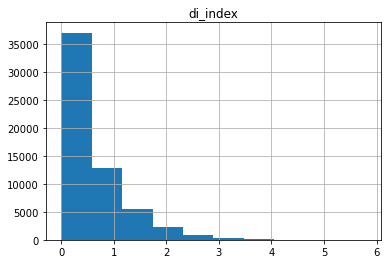

In [46]:
# Looking at the distribution of DI_Index across the comorbidities set.. 
print(death_indexes.di_index.describe())
death_indexes.hist(column='di_index')

# Seems like there is meaningful variation in the data!!!

In [47]:
death_indexes.head()

,di_index,hadm_id
HADM_ID,,
100001,0.256886,100001
100003,0.578856,100003
100006,1.397467,100006
100007,0.988205,100007
100009,0.008227,100009


In [48]:
# Re-indexing dataframe
death_indexes.reset_index(inplace=True,drop=True)
death_indexes['hadm_id'] = death_indexes['hadm_id'].astype('int')

In [49]:
# What we have below is the di_index ready to be merged into both the training and test data...
death_indexes.head()

,di_index,hadm_id
0,0.256886,100001
1,0.578856,100003
2,1.397467,100006
3,0.988205,100007
4,0.008227,100009


In [50]:
# Creating a copy of the earlier death predictions data frame with
# hospital expiry 0 | hospital_expiry 1 | di_index | ICD9_CODE
death_preds_c = death_preds.copy()
death_preds_c.rename(columns = {'di_index' : 'di_index_main'},inplace=True)
death_preds_c.head()

HOSPITAL_EXPIRE_FLAG,0,1,di_index_main,ICD9_CODE
ICD9_diagnosis,,,,
0389,683.0,289.0,0.297325,0389
431,308.0,107.0,0.257831,431
51881,308.0,83.0,0.212276,51881
430,181.0,42.0,0.188341,430
486,272.0,40.0,0.128205,486


### Merging di_index into training data

In [51]:
# STARTING WITH THE TRAINING DATA

# We begin by migrating the comorbidities di_index to the training dataset
training.rename(columns = {'ICD9_diagnosis' : 'ICD9_CODE'}, inplace = True) 
training_merged=training.merge(death_indexes[['hadm_id','di_index']],how='left',on='hadm_id')

# Next, we need to match the co-morbidities
training_merged=training_merged.merge(death_preds_c[['ICD9_CODE','di_index_main']],how='left',on='ICD9_CODE')

# Deleting the temporary columns...
training_merged.drop(['di_index_main'],1,inplace=True)

# Checking if we have NaNs...
print(training_merged.di_index.isna().value_counts())

# Visualizing the result
training_merged.head()

False    20885
Name: di_index, dtype: int64


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_CODE,FIRST_CAREUNIT,LOS,di_index
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761,0.852726
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582,0.000000
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626,1.199769
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734,0.776220
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654,1.211302


### Merging di_index into test data

In [52]:
# CONTINUING WITH THE TEST DATA

# We begin by migrating the comorbidities di_index to the test dataset
test.rename(columns = {'ICD9_diagnosis' : 'ICD9_CODE'}, inplace = True) 
test_merged=test.merge(death_indexes[['hadm_id','di_index']],how='left',on='hadm_id')

# Next, we need to match the co-morbidities
test_merged=test_merged.merge(death_preds_c[['ICD9_CODE','di_index_main']],how='left',on='ICD9_CODE')

# Deleting the temporary columns...
test_merged.drop(['di_index_main'],1,inplace=True)

# Checking if we have NaNs..
print(test_merged.di_index.isna().value_counts())

# Visualizing the result
test_merged.head()

False    5221
Name: di_index, dtype: int64


,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_CODE,FIRST_CAREUNIT,di_index
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,-67454.42740,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU,0.417914
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,-34204.08546,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,HYPERGLYCEMIA,25013,MICU,0.971712
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,-38710.61714,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,KIDNEY STONES/SDA,5920,MICU,1.511370
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,-54902.54313,EMERGENCY,Private,EPISCOPALIAN,WIDOWED,WHITE,RIGHT FEMUR FRACTURE,82120,CCU,1.364361
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,-33906.93488,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU,1.114860


## Feature Engineering

In [53]:
training_merged.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_CODE',
       'FIRST_CAREUNIT', 'LOS', 'di_index'],
      dtype='object')

In [54]:
test_merged.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_CODE',
       'FIRST_CAREUNIT', 'di_index'],
      dtype='object')

## 2.1) Training data

In [55]:
# narrowing down the glucose levels as they are way too high for some... (outlier deletion)
training = training[training.Glucose_Max < 1000]
training = training[training.Glucose_Mean < 1000]

In [56]:
# CHOOSING WHICH COLUMNS I WANT TO DUMMIFY...
training = pd.get_dummies(training_merged, prefix=['INSURED'], columns=['INSURANCE'], drop_first = True)
training = pd.get_dummies(training, prefix=['SEX'], columns=['GENDER'], drop_first = True)
#training = pd.get_dummies(training, prefix=['ICD9'], columns=['ICD9_diagnosis'], drop_first = True)
training = pd.get_dummies(training, prefix=['ADM_T'], columns=['ADMISSION_TYPE'], drop_first = True)
#training = pd.get_dummies(training, prefix=['MAR_STAT'], columns=['MARITAL_STATUS'], drop_first = True)
training = pd.get_dummies(training, prefix=['FST_CAR'], columns=['FIRST_CAREUNIT'], drop_first = True)
#training = pd.get_dummies(training, prefix=['REL'], columns=['RELIGION'], drop_first = True)
#training = pd.get_dummies(training, prefix =['DIAG'], columns = ['DIAGNOSIS'], drop_first = True)
#training = pd.get_dummies(training, prefix=['ETH'], columns=['ETHNICITY'], drop_first = True)

In [57]:
# Computing age variable (can't use a simple difference as this leads to overflow error...)
training['ADMITTIME'] = pd.to_datetime(training['ADMITTIME'])
training['DOB'] = pd.to_datetime(training['DOB'])
training['age'] = [relativedelta(a, b).years for a, b in zip(training['ADMITTIME'], training['DOB'])]

In [58]:
# Dropping all irrelevant columns (both out of project prompt and found through tinkering)
training.drop(['hadm_id','subject_id'],1,inplace=True)
training.drop(['icustay_id','DOB','DOD','ADMITTIME','DISCHTIME','DEATHTIME','Diff','LOS','DIAGNOSIS'],1,inplace=True)
training.drop(['MARITAL_STATUS'],1,inplace=True)
training.drop(['ICD9_CODE'],1,inplace=True)
training.drop(['RELIGION'],1,inplace=True)
training.drop(['ETHNICITY'],1,inplace=True)

In [59]:
training.columns[1:50]

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'di_index', 'INSURED_Medicaid', 'INSURED_Medicare',
       'INSURED_Private', 'INSURED_Self Pay', 'SEX_M', 'ADM_T_EMERGENCY',
       'ADM_T_URGENT', 'FST_CAR_CSRU', 'FST_CAR_MICU', 'FST_CAR_SICU',
       'FST_CAR_TSICU', 'age'],
      dtype='object')

In [60]:
# Imputing means on the training data
# Imputing means for each category that have missing values...
for col in training.columns.tolist():
  col = str(col)
  if 'Min' in col:
    training[col] = training[col].fillna(training[col].mean())
  if 'Max' in col:
    training[col] = training[col].fillna(training[col].mean())
  if 'Mean' in col:
    training[col] = training[col].fillna(training[col].mean())

# Checking that we have gotten rid of NaNs...
training.isnull().values.any()

False

In [61]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20885 entries, 0 to 20884
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   HeartRate_Min         20885 non-null  float64
 2   HeartRate_Max         20885 non-null  float64
 3   HeartRate_Mean        20885 non-null  float64
 4   SysBP_Min             20885 non-null  float64
 5   SysBP_Max             20885 non-null  float64
 6   SysBP_Mean            20885 non-null  float64
 7   DiasBP_Min            20885 non-null  float64
 8   DiasBP_Max            20885 non-null  float64
 9   DiasBP_Mean           20885 non-null  float64
 10  MeanBP_Min            20885 non-null  float64
 11  MeanBP_Max            20885 non-null  float64
 12  MeanBP_Mean           20885 non-null  float64
 13  RespRate_Min          20885 non-null  float64
 14  RespRate_Max          20885 non-null  float64
 15  RespRate_Mean      

## 2.2) Test data

In [62]:
# CHOOSING WHICH COLUMNS I WANT TO DUMMIFY... (has to match training choice)
test = pd.get_dummies(test_merged, prefix=['INSURED'], columns=['INSURANCE'], drop_first = True)
test = pd.get_dummies(test, prefix=['SEX'], columns=['GENDER'], drop_first = True)
#test = pd.get_dummies(test, prefix=['ICD9'], columns=['ICD9_diagnosis'], drop_first = True)
test = pd.get_dummies(test, prefix=['ADM_T'], columns=['ADMISSION_TYPE'], drop_first = True)
#test = pd.get_dummies(test, prefix=['MAR_STAT'], columns=['MARITAL_STATUS'], drop_first = True)
test = pd.get_dummies(test, prefix=['FST_CAR'], columns=['FIRST_CAREUNIT'], drop_first = True)
#test = pd.get_dummies(test, prefix=['REL'], columns=['RELIGION'], drop_first = True)
#test = pd.get_dummies(test, prefix =['DIAG'], columns = ['DIAGNOSIS'], drop_first = True)
#test = pd.get_dummies(test, prefix=['ETH'], columns=['ETHNICITY'], drop_first = True)

In [63]:
# Computing age variable (can't use a simple difference as this leads to overflow error...)
test['ADMITTIME'] = pd.to_datetime(test['ADMITTIME'])
test['DOB'] = pd.to_datetime(test['DOB'])
test['age'] = [relativedelta(a, b).years for a, b in zip(test['ADMITTIME'], test['DOB'])]

In [64]:
# Dropping all irrelevant columns (both out of project prompt and found through tinkering)
test.drop(['DOB','ADMITTIME','Diff','DIAGNOSIS'],1,inplace=True)
test.drop(['hadm_id'],1,inplace=True)
test.drop(['MARITAL_STATUS','ICD9_CODE'],1,inplace=True)
test.drop(['ETHNICITY'],1,inplace=True)
test.drop(['RELIGION'],1,inplace=True)
test_for_processing = test.drop(['icustay_id'],1)

In [65]:
# we will proceed by using the means from the test set data...
for col in test_for_processing.columns.tolist():
  col = str(col)
  if 'Min' in col:
    test_for_processing[col] = test_for_processing[col].fillna(test_for_processing[col].mean())
  if 'Max' in col:
    test_for_processing[col] = test_for_processing[col].fillna(test_for_processing[col].mean())
  if 'Mean' in col:
    test_for_processing[col] = test_for_processing[col].fillna(test_for_processing[col].mean())

# Checking that we have gotten rid of NaNs...
test_for_processing.isnull().values.any()

False

In [66]:
test_for_processing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5221 entries, 0 to 5220
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        5221 non-null   int64  
 1   HeartRate_Min     5221 non-null   float64
 2   HeartRate_Max     5221 non-null   float64
 3   HeartRate_Mean    5221 non-null   float64
 4   SysBP_Min         5221 non-null   float64
 5   SysBP_Max         5221 non-null   float64
 6   SysBP_Mean        5221 non-null   float64
 7   DiasBP_Min        5221 non-null   float64
 8   DiasBP_Max        5221 non-null   float64
 9   DiasBP_Mean       5221 non-null   float64
 10  MeanBP_Min        5221 non-null   float64
 11  MeanBP_Max        5221 non-null   float64
 12  MeanBP_Mean       5221 non-null   float64
 13  RespRate_Min      5221 non-null   float64
 14  RespRate_Max      5221 non-null   float64
 15  RespRate_Mean     5221 non-null   float64
 16  TempC_Min         5221 non-null   float64


## Model Fitting / Predicting Using Pipeline


### General comments

- Notice that below I am constructing a imblearn Pipeline, in order for me to be able to do the model fitting and analysis in a more neat way.
- For the SVC algorithm, I noticed that the best performance was consistently reached at svc_C = .4, svc_kernel = 'poly',svc_degree = 3. Anything above and below would fare worse.
- For the sake of efficiency I have tidied the below pipeline to only use these parameters...

### Pipeline construction comments
In my Pipeline, I am using the following components:

1) RandomUnderSampler from the imblearn library,
- The reason why I am undersampling is to avoid long computation times... (this tackles the class imbalance issue at hand with way more HOSPITAL_EXPIRE_FLAG 0s than 1s in the training data)...
- An alternative to this is using Tomek-Links undersampling from the imblearn library, which removes ambiguous examples. I don't know the effective sample size that comes out of this, as it depends on each CV.. (it also does worse that RandomUnderSampler).

2) StandardScaler from the sklearn library,

3) SVC classifier from sklearn.

In [67]:
# Defining the scaler to be used in the pipeline
scaler = StandardScaler()

# Defining the undersampler to be used in the pipeline
samplr = RandomUnderSampler()

# Defining our model to be used in the pipeline
svc = SVC(probability = True)

# Defining our final pipeline to be used 
pipeline = Pipeline([('samplr',samplr),
                     ('scaler',scaler),
                     ('feat_sel',SelectFromModel(LinearSVC(penalty="l1",dual=False))),
                     ('svc',svc)])

In [68]:
# Best setup for the SCV classifier, found by extensive tinkering...
grid_params = {'svc__kernel' : ['poly'], 'svc__degree' : [3], 'svc__C' : [.4]}

In [69]:
# Simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [70]:
# Printing the setup to make sure it's alright.
print(pipeline)

Pipeline(steps=[('samplr', RandomUnderSampler()), ('scaler', StandardScaler()),
                ('feat_sel',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('svc', SVC(probability=True))])


In [71]:
# Setting up the search grid, and having a look at what I can change should I wish to...
grid = GridSearchCV(pipeline, param_grid = grid_params, cv = 5, scoring = 'roc_auc')
grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__samplr', 'estimator__scaler', 'estimator__feat_sel', 'estimator__svc', 'estimator__samplr__random_state', 'estimator__samplr__replacement', 'estimator__samplr__sampling_strategy', 'estimator__scaler__copy', 'estimator__scaler__with_mean', 'estimator__scaler__with_std', 'estimator__feat_sel__estimator__C', 'estimator__feat_sel__estimator__class_weight', 'estimator__feat_sel__estimator__dual', 'estimator__feat_sel__estimator__fit_intercept', 'estimator__feat_sel__estimator__intercept_scaling', 'estimator__feat_sel__estimator__loss', 'estimator__feat_sel__estimator__max_iter', 'estimator__feat_sel__estimator__multi_class', 'estimator__feat_sel__estimator__penalty', 'estimator__feat_sel__estimator__random_state', 'estimator__feat_sel__estimator__tol', 'estimator__feat_sel__estimator__verbose', 'estimator__feat_sel__estimator', 'estimator__feat_sel__importance_getter', 'estimator__feat

In [72]:
# Fitting the actual grid...
grid.fit(np.array(training.drop(['HOSPITAL_EXPIRE_FLAG'],1)),np.array(training['HOSPITAL_EXPIRE_FLAG']))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('samplr', RandomUnderSampler()),
                                       ('scaler', StandardScaler()),
                                       ('feat_sel',
                                        SelectFromModel(estimator=LinearSVC(dual=False,
                                                                            penalty='l1'))),
                                       ('svc', SVC(probability=True))]),
             param_grid={'svc__C': [0.4], 'svc__degree': [3],
                         'svc__kernel': ['poly']},
             scoring='roc_auc')

In [76]:
# Gauging the best performing estimator
clf_performance(grid,'SVM')

SVM
Best Score: 0.8418099056267436
Best Parameters: {'svc__C': 0.4, 'svc__degree': 3, 'svc__kernel': 'poly'}


In [77]:
# Predicting using the best estimator.
y_hat_clf_svm = grid.best_estimator_.predict_proba(test_for_processing.drop(['subject_id'],1))

In [78]:
# Taking our predictions and putting them in a list for final format...
empty_list = []
for observation in y_hat_clf_svm:
  empty_list.append(observation[1])
print(empty_list)

final_pred = np.array(empty_list)


[0.04884404904682216, 0.8982039222503554, 0.46817980130741227, 0.4364109439515714, 0.5271022951902581, 0.06387131630523989, 0.001691472861210546, 0.3304003939680931, 0.035766912604768414, 0.06079799361188518, 0.5163258185376636, 0.8317341942728931, 0.9950960660211764, 0.8208457242202933, 0.37756050417037507, 0.29986749128197365, 0.8598171002584429, 0.26510624246324105, 0.4363398354040733, 0.39844486568975074, 0.7993978265301463, 0.2850514651280435, 0.520875064245832, 0.6635072100062281, 0.5941581545589001, 0.7051260163720069, 0.2981139543934007, 0.18005031780885777, 0.3331277134749647, 0.20482511025486622, 0.4396583242287081, 0.6607663388020019, 0.9463057985718774, 0.19741358517679697, 0.5, 0.18426687081382873, 0.24667948062739434, 0.3014768586648639, 0.506517811382544, 0.04282940849614617, 0.5192399753041194, 0.9727355414445055, 0.08535587606276984, 0.3031047698765572, 0.161666909090708, 0.10518200388303099, 0.033910818729574695, 0.16801335096985576, 0.5116156065662355, 0.442273312053

In [79]:
# Saving the final submission, for uploading...
final_data = {'icustay_id': test.icustay_id, 'HOSPITAL_EXPIRE_FLAG': final_pred}
submission = pd.DataFrame(data=final_data)
submission.to_csv(os.path.join(fl,'processed_data/predicted_deaths.csv'), index =False)